In [ ]:
# !pip install pm4py

In [21]:
from phase_bpmn import bpmnToDict
from event_log import write_log
import logging
from datetime import datetime
import time

import pandas as pd
import pm4py

import random

In [22]:
"""
process_dict
    dictionary storing the whole process, process id as key
"""
process_dict = bpmnToDict("resources/bpmn.bpmn")

In [23]:
#Config
log_id = 1;
#Variables
process_path = list();
#for parallel gateway
current_layer = 0;
current_In_Layer = 0;
handled_gateway = []


In [24]:
for key, value in process_dict.items():
    print(key,":", value)

file_number : {http://www.omg.org/spec/BPMN/20100524/MODEL}
Event_0lnxcvl : {'name': 'Start Process of applying new bank account', 'type': 'startEvent', 'outgoing': ['Flow_0c182ag']}
Gateway_03yfk3z : {'type': 'exclusiveGateway', 'incoming': ['Flow_0c182ag'], 'outgoing': ['Flow_1qhk0r6', 'Flow_0ucqptd']}
Flow_0c182ag : 
Activity_1w0ol9m : {'name': 'Upload personal identification documents', 'type': 'task', 'incoming': ['Flow_1qhk0r6'], 'outgoing': ['Flow_18zh6fq']}
Flow_1qhk0r6 : Apply Online
Activity_1i97yd8 : {'name': 'Fill in application form with branch staff', 'type': 'task', 'incoming': ['Flow_0ucqptd'], 'outgoing': ['Flow_01yrhkw']}
Flow_0ucqptd : Apply physically at branch
Activity_16mb7wz : {'name': 'eKYC process', 'type': 'task', 'incoming': ['Flow_18zh6fq'], 'outgoing': ['Flow_0ncdvpk']}
Flow_18zh6fq : 
Flow_0ncdvpk : 
Gateway_1djuzpp : {'type': 'parallelGateway', 'incoming': ['Flow_10c1mgx'], 'outgoing': ['Flow_11asr0r', 'Flow_1du3rrg']}
Activity_0yhv72e : {'name': 'Verify 

In [25]:
# find the start and end event in the process_dict
# for keys,values in process_dict.items():
#     if 'outgoing' in values and 'incoming' not in values:
#         start_event =keys
#         logging.info("start_event=" + start_event)
#     if 'incoming' in values and 'outgoing' not in values:
#         end_event =keys
#         logging.info("end_event=" + end_event)

In [26]:
# find the start and end event in the process_dict
start_event, end_event = ("","")
for keys, values in process_dict.items():
    if 'type' in values:
        for value in values.values():
            if value == "startEvent":
                start_event = keys
                logging.info("start_event=" + start_event)
            elif value == "endEvent":
                end_event = keys
                logging.info("end_event=" + end_event)
#raise error if startEvent or endEvent not found
if start_event == "" or end_event == "":
    raise Exception("Your bpmn process must contain a startEvent and endEvent.")

In [27]:
# #start process
# write_log(1,process_dict[start_event]['name'])


In [28]:
print(start_event,end_event)

Event_0lnxcvl Event_1acmirw


In [29]:
#function for add to Main path
def addToMainPath(idstr: str):
    process_path.append(idstr)

In [30]:
def check_outgoing_number(processDict: dict, event_id:str):
    detail_of_given_id = processDict[event_id]
    try:
        outgoing = detail_of_given_id["outgoing"]
    except:
        outgoing = ""
    return len(outgoing)
print(check_outgoing_number(process_dict, end_event))

0


In [31]:
#used when return from check_outgoing_number return > 1
def checkType(processDict: dict, event_id:str):
    detail_of_given_id = processDict[event_id]
    if  isinstance(detail_of_given_id, list) or isinstance(detail_of_given_id, str):
        type_of_event = "flow"
    else:
        type_of_event = detail_of_given_id["type"]
        
    return type_of_event
print(checkType(process_dict, process_dict[start_event]["outgoing"][0]))

flow


In [32]:
#check if outgoing flow have content, if do, add in main path
def checkAndAddFlowToMain(processDict: dict, flow_id: str):
    flow_detail = processDict[flow_id]
    if len(flow_detail) > 0:
        process_path.append(flow_id)
        print(flow_detail)
        return True
    else:
        return False
# print(checkAndAddFlowToMain(process_dict, "Flow_0ucqptd"))

In [33]:
#pass in current id's outgoing, find next
#Flow_0c182ag
def findNextWithOneOutgoing(processDict: dict, flow_id: str):
    target_event_id = ""
    for event in processDict:
        event_detail = processDict[event]
        if isinstance(event_detail, dict):
            if "incoming" in event_detail:
                if flow_id in event_detail["incoming"]:
                    target_event_id = event
    return target_event_id
print(findNextWithOneOutgoing(process_dict, "Flow_0c182ag"))

Gateway_03yfk3z


In [34]:
#Process
def process_current_and_get_next(processDict: dict, current_id: str):
    current_type = checkType(processDict, current_id)
    if current_type != "exclusiveGateway" and current_type != "parallelGateway":
        #Normal path
        current_outgoing_number = check_outgoing_number(processDict, current_id)
        if current_outgoing_number > 1:
            raise Exception("Non-gateway event can only contain one outgoing path.")
        elif current_outgoing_number == 0:
            print(current_outgoing_number)
            if current_type == "endEvent":
                print(current_type)
                #EndEvent
                addToMainPath(current_id)
                return False
            else:
                raise Exception("Event must contain outgoing.")
        elif current_outgoing_number == 1:
            addToMainPath(current_id)
            checkAndAddFlowToMain(processDict, processDict[current_id]["outgoing"][0])
            return findNextWithOneOutgoing(processDict, processDict[current_id]["outgoing"][0])
        else:
            raise Exception("Events have no outgoing.")
    else:
        if current_type == "exclusiveGateway":
            #TODO: random generate a number for different path
            current_outgoing_number = check_outgoing_number(processDict, current_id)
            random_path = random.randint(1,current_outgoing_number)
            random_next_event = processDict[current_id]["outgoing"][random_path-1]
            handled_gateway.append(current_id)
            return findNextWithOneOutgoing(processDict, random_next_event)
        elif current_type == "parallelGateway":
            #TODO: parallel gateway path
            if len(processDict[current_id]["outgoing"])>1:
                return findNextWithOneOutgoing(processDict, processDict[current_id]["outgoing"][1])
            else:
                return findNextWithOneOutgoing(processDict, processDict[current_id]["outgoing"][0])
        else:
            raise Exception("Wrong gateway type found")
            
        
# print(process_current_and_get_next(process_dict, "Gateway_03yfk3z"))
# print(process_path)

In [35]:
current_event = start_event
print(current_event)
while current_event != end_event:
    new_event = process_current_and_get_next(process_dict, current_event)
    current_event = new_event
    print(current_event)
print(process_path)

Event_0lnxcvl
Gateway_03yfk3z
Activity_1i97yd8
Gateway_0nybhjf
Gateway_1djuzpp
Activity_0z136np
Gateway_1wwtoq2
Gateway_0mmdsy6
Activity_171f4h4
Gateway_0vppjg9
Event_1acmirw
['Event_0lnxcvl', 'Activity_1i97yd8', 'Activity_0z136np', 'Activity_171f4h4']


In [36]:
print(handled_gateway)

['Gateway_03yfk3z', 'Gateway_0nybhjf', 'Gateway_0mmdsy6', 'Gateway_0vppjg9']


In [37]:
#Start Loging event
if process_path != None:
    for event in process_path:
        event_name =  process_dict[event]['name']
        import_time = datetime.now()
        write_log(log_id,event_name,import_time)
        time.sleep(0.5)

In [38]:
#File type transformation
read_file = pd.read_csv("event_log.txt",sep='\t')
read_file.to_csv('event_log.csv', index=None, sep = ';')
#print(read_file)

In [39]:
#PM4PY handling
def import_csv(file_path):
    dataframe = pd.read_csv(file_path, sep=';')
    dataframe = pm4py.format_dataframe(dataframe, case_id='LogID', activity_key='Event', timestamp_key='Time')
#     event_log = pm4py.convert_to_event_log(dataframe)
#     print(event_log)
    process_tree = pm4py.discover_bpmn_inductive(dataframe)
    pm4py.view_bpmn(process_tree)

C:\Users\Arthur Siu\AppData\Local\Temp\ipykernel_22376\1753651738.py:4: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  dataframe = pm4py.format_dataframe(dataframe, case_id='LogID', activity_key='Event', timestamp_key='Time')


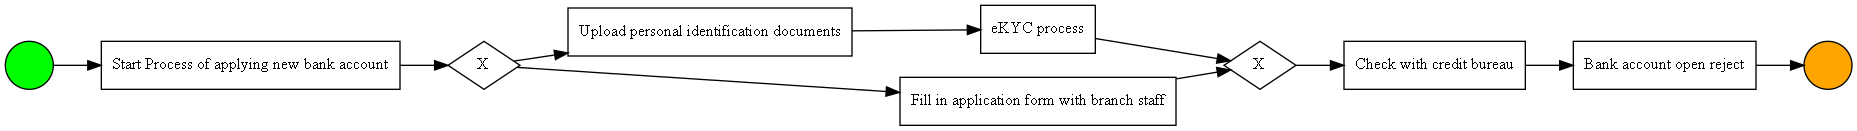

In [40]:
import_csv("event_log.csv")

In [ ]:
pm4py.format_dataframe?